In [1]:
import jax 
import jax.numpy as jnp

import flax

import chex

import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.cma_mega_emitter_v2 import CMAMEGAEmitter
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.core.neuroevolution.mdp_utils import generate_unroll
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.metrics import CSVLogger, default_qd_metrics
from qdax import environments

from typing import Dict, Callable, Tuple
from qdax.types import Genotype, Fitness, ExtraScores, Params, RNGKey, EnvState, Descriptor
import functools

2025-11-21 11:09:51.713346: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 200 #@param {type:"integer"}
num_centroids = 10000 #@param {type:"integer"}
minval = 0.0 #@param {type:"number"}
maxval = 1.0 #@param {type:"number"}
batch_size = 100 #@param {type:"integer"}
learning_rate = 1 #@param {type:"number"}
sigma_g = 3.16 #@param {type:"number"} # square root of 10, the value given in the paper
es_noise = 0.02
#@markdown ---

seed = 0
env_batch_size = 100 # batch size for cma
es_batch_size = 100 # batch size to approximate gradient
env_name = "walker2d_uni"
episode_length = 1000
policy_hidden_layer_sizes = (16, 16) #@param {type:"raw"}\
mirrored_sampling = False

## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [3]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=env_batch_size)
fake_batch = jnp.zeros(shape=(env_batch_size, env.observation_size))
# init with zero mean and es_noise std
init_variables = jax.vmap(policy_network.init)(keys, fake_batch) #init randomly first
num_leaves = len(jax.tree_util.tree_leaves(init_variables))
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num_leaves)
keys_tree = jax.tree_util.tree_unflatten(
    jax.tree_util.tree_structure(init_variables),
    keys
)
init_variables = jax.tree_util.tree_map(
    lambda x, k: jax.random.normal(k, x.shape) * es_noise,
    init_variables, keys_tree 
)

# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=env_batch_size, axis=0)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states = reset_fn(keys)

## Define the way the policy interacts with the env

In [4]:
# Define the fonction to play a step with the policy in the environment
def play_step_fn(
  env_state,
  policy_params,
  random_key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)
    
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, random_key, transition

In [5]:
@functools.partial(
    jax.jit,
    static_argnames=(
        "episode_length",
        "play_step_fn",
        "behavior_descriptor_extractor",
    ),
)
def scoring_function_brax_envs(
    policies_params: Genotype,
    random_key: RNGKey,
    init_states: EnvState,
    episode_length: int,
    play_step_fn: Callable[
        [EnvState, Params, RNGKey], Tuple[EnvState, Params, RNGKey, QDTransition]
    ],
    behavior_descriptor_extractor: Callable[[QDTransition, jnp.ndarray], Descriptor],
) -> Tuple[Fitness, Descriptor, ExtraScores, RNGKey]:
    """Evaluates policies contained in policies_params in parallel in
    deterministic or pseudo-deterministic environments.

    This rollout is only deterministic when all the init states are the same.
    If the init states are fixed but different, as a policy is not necessarily
    evaluated with the same environment everytime, this won't be determinist.
    When the init states are different, this is not purely stochastic.

    Args:
        policies_params: The parameters of closed-loop controllers/policies to evaluate.
        random_key: A jax random key
        episode_length: The maximal rollout length.
        play_step_fn: The function to play a step of the environment.
        behavior_descriptor_extractor: The function to extract the behavior descriptor.

    Returns:
        fitness: Array of fitnesses of all evaluated policies
        descriptor: Behavioural descriptors of all evaluated policies
        extra_scores: Additional information resulting from evaluation
        random_key: The updated random key.
    """

    # Perform rollouts with each policy
    random_key, subkey = jax.random.split(random_key)
    unroll_fn = functools.partial(
        generate_unroll,
        episode_length=episode_length,
        play_step_fn=play_step_fn,
        random_key=subkey,
    )

    _final_state, data = jax.vmap(unroll_fn)(init_states, policies_params)

    # create a mask to extract data properly
    is_done = jnp.clip(jnp.cumsum(data.dones, axis=1), 0, 1)
    mask = jnp.roll(is_done, 1, axis=1)
    mask = mask.at[:, 0].set(0)

    # scores
    fitnesses = jnp.sum(data.rewards * (1.0 - mask), axis=1)
    descriptors = behavior_descriptor_extractor(data, mask)


    return (
        fitnesses,
        descriptors,
        {
            "transitions": data,
        },
        random_key,
    )

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and behavior descriptor of each individual. 

In [6]:
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function_brax_envs,
    init_states=init_states,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)


In [7]:
# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

In [8]:
centroids, random_key = compute_cvt_centroids(
    num_descriptors=2, 
    num_init_cvt_samples=10000, 
    num_centroids=num_centroids, 
    minval=minval, 
    maxval=maxval,
    random_key=random_key,
)

emitter = CMAMEGAEmitter(
    scoring_function=scoring_fn,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_descriptors=2,
    centroids=centroids,
    sigma_g=sigma_g,
    exact_gradient=False,
    es_batch_size=es_batch_size,
    es_noise=es_noise
)

map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
    metrics_function=metrics_function,
)

In [9]:
repertoire, emitter_state, random_key = map_elites.init(init_variables, centroids, random_key)

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 16, 3)
gradient shape at estimate ES (1, 17, 16, 3)
gradient shape at estimate ES (1, 16, 3)
gradient shape at estimate ES (1, 16, 16, 3)
gradient shape at estimate ES (1, 6, 3)
gradient shape at estimate ES (1, 16, 6, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (17, 16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (16, 16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (6, 3)
coeffs shape Traced<Sh

In [10]:
# %%time

log_period = 10
num_loops = num_iterations // log_period

for i in range(num_loops):
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites.scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=num_iterations,
    )
    metrics_str = " ".join([f"{k}: {v[-1]}" for k, v in metrics.items()])
    print(f"loop: {i} {metrics_str}")

IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 16, 3)
gradient shape at estimate ES (1, 17, 16, 3)
gradient shape at estimate ES (1, 16, 3)
gradient shape at estimate ES (1, 16, 16, 3)
gradient shape at estimate ES (1, 6, 3)
gradient shape at estimate ES (1, 16, 6, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (17, 16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (16, 16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (6, 3)
coeffs shape Traced<Sh

In [11]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 20000: 66.91999816894531
imp_cross after 20000: 0.0
imp_mut after 20000: 0.0
imp_var after 20000: 432.5976867675781
max_fitness after 20000: 1126.982666015625
qd_score after 20000: 12341772.0
succ_cross after 20000: 0
succ_mut after 20000: 0
succ_var after 20000: 13


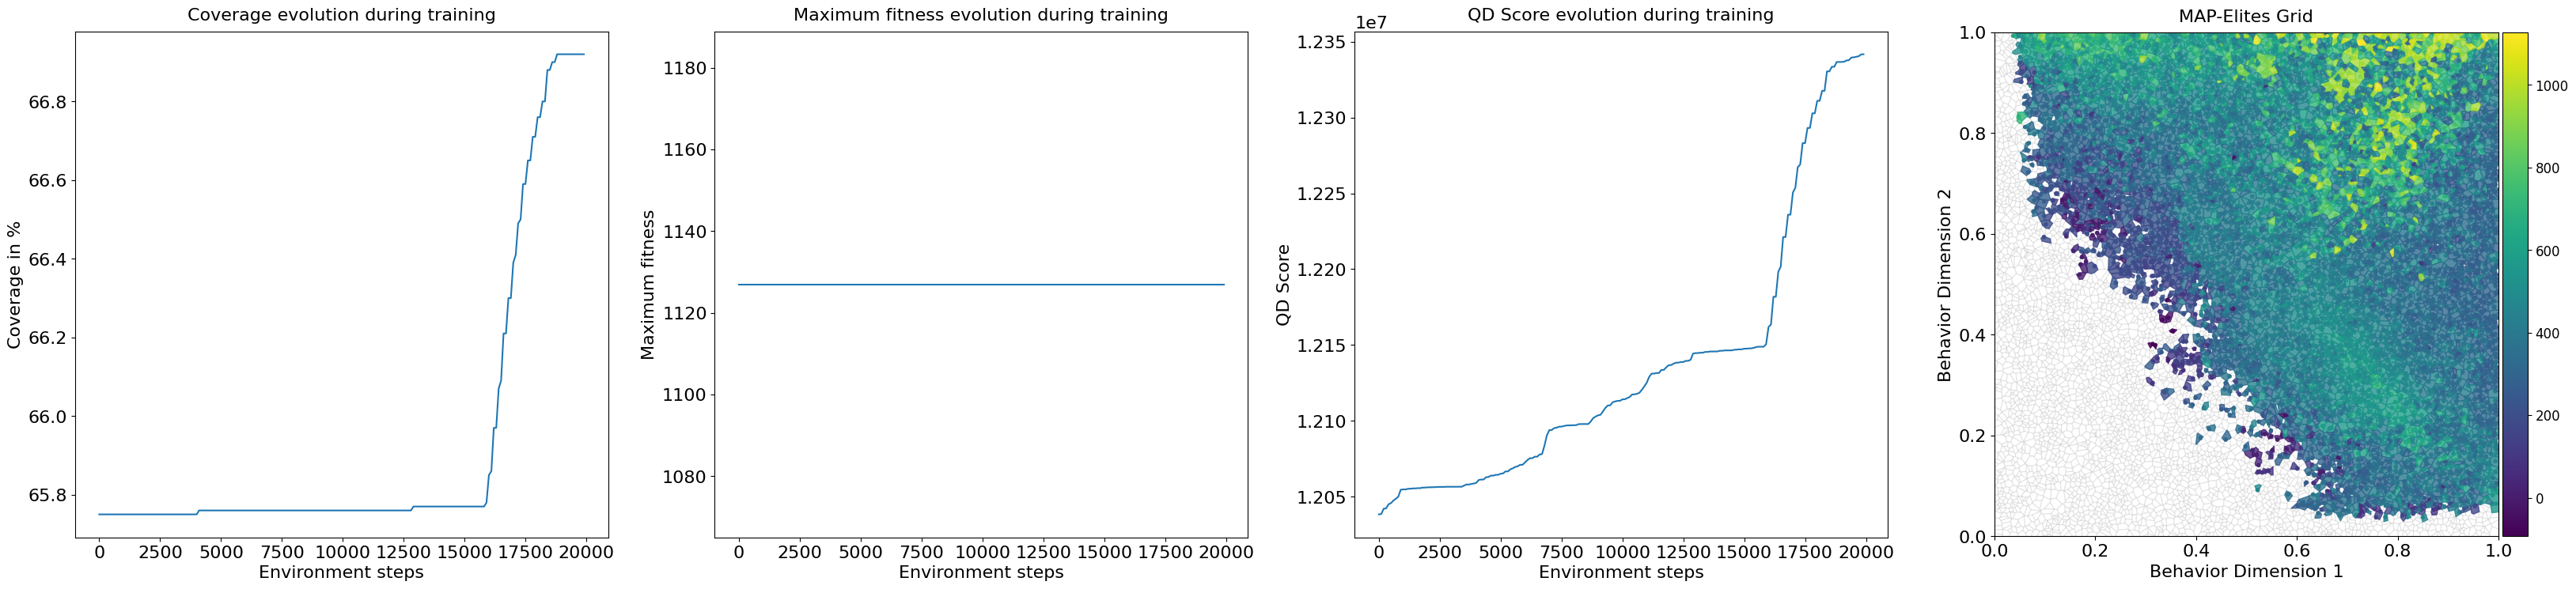

In [12]:
%matplotlib inline
#@title Visualization

# create the x-axis array
env_steps = jnp.arange(num_iterations) * batch_size

# create the plots and the grid
fig, axes = plot_map_elites_results(
    env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=minval, max_bd=maxval
)